In [33]:
from cifar10_dcgan import Generator, Discriminator
import torchvision
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn, optim
import matplotlib.pyplot as plt

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

data = torchvision.datasets.CIFAR10(
    root="cifar10",
    train = True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset=data, batch_size=16, shuffle=True)

Files already downloaded and verified


In [35]:
noise_channels = 100
image_channels = 3
features = 16
device = "cuda"
fixed_noise = torch.randn((16, noise_channels, 1, 1)).to(device)

generator = Generator(noise_channels, image_channels, features).to(device)
discriminator = Discriminator(image_channels, features).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=3e-4)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4)

criterion = nn.BCELoss()

generator_loss_history = []
discriminator_loss_history = []

In [36]:
epochs = 100

for epoch in range(epochs):
    generator.train()
    discriminator.train()
    
    for batch, (image, _) in enumerate(loader):
        image = image.to(device)
        bs = image.shape[0]

        # --- Discriminator Training --- #
        noise = torch.randn((bs, noise_channels, 1, 1)).to(device)
        fake_image = generator(noise)

        real_guess = discriminator(image)
        fake_guess = discriminator(fake_image)

        real_loss = criterion(real_guess, torch.ones_like(real_guess))
        fake_loss = criterion(fake_guess, torch.zeros_like(fake_guess))

        discriminator_loss = real_loss + fake_loss
        discriminator.zero_grad()
        discriminator_loss.backward(retain_graph=True)
        disc_optimizer.step()

        # --- Generator Training --- #
        judgement = discriminator(fake_image)
        generator_loss = criterion(judgement, torch.ones_like(fake_guess))
        generator.zero_grad()
        generator_loss.backward()
        gen_optimizer.step()
        
        if batch % 100 == 0:
            generator_loss_history.append(generator_loss.detach().cpu())
            discriminator_loss_history.append(discriminator_loss.detach().cpu())

    print(
        f"Epoch {epoch+1}/{epochs} | Generator Loss: {generator_loss_history[-1]} | Discriminator Loss: {discriminator_loss_history[-1]}"
    )
    generator.eval()
    images = generator(fixed_noise).detach().cpu()
    images = (images + 1)/2
    torchvision.utils.save_image(images, f"cifar_10_generated/{epoch+1}.png", nrow=4)
    

Epoch 1/100 | Generator Loss: 3.224931240081787 | Discriminator Loss: 0.34510934352874756
Epoch 2/100 | Generator Loss: 4.1505961418151855 | Discriminator Loss: 0.12643863260746002
Epoch 3/100 | Generator Loss: 3.664518117904663 | Discriminator Loss: 0.06394302845001221
Epoch 4/100 | Generator Loss: 2.6641154289245605 | Discriminator Loss: 0.15364021062850952
Epoch 5/100 | Generator Loss: 1.7132502794265747 | Discriminator Loss: 0.5700502395629883
Epoch 6/100 | Generator Loss: 6.064531326293945 | Discriminator Loss: 0.021548619493842125
Epoch 7/100 | Generator Loss: 8.228599548339844 | Discriminator Loss: 0.008648130111396313
Epoch 8/100 | Generator Loss: 4.517831802368164 | Discriminator Loss: 0.025855356827378273
Epoch 9/100 | Generator Loss: 4.179678916931152 | Discriminator Loss: 0.46821343898773193
Epoch 10/100 | Generator Loss: 5.531898498535156 | Discriminator Loss: 0.7215443849563599
Epoch 11/100 | Generator Loss: 2.8143746852874756 | Discriminator Loss: 0.5865343809127808
Epoc

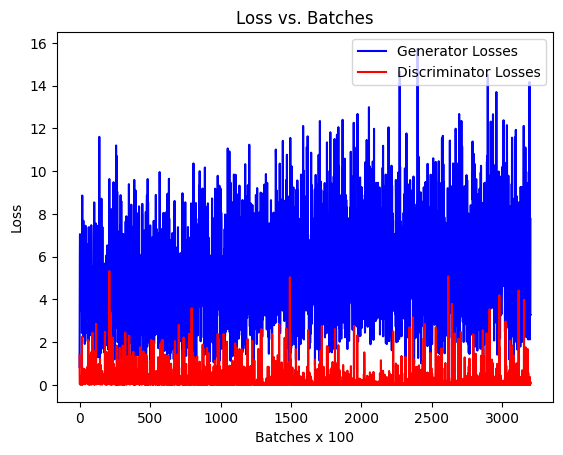

In [37]:
x_axis = range(len(generator_loss_history))

plt.plot(x_axis, generator_loss_history, color="blue", label="Generator Losses")
plt.plot(x_axis, discriminator_loss_history, color="red", label="Discriminator Losses")
plt.title("Loss vs. Batches")
plt.xlabel("Batches x 100")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("loss_history.png")

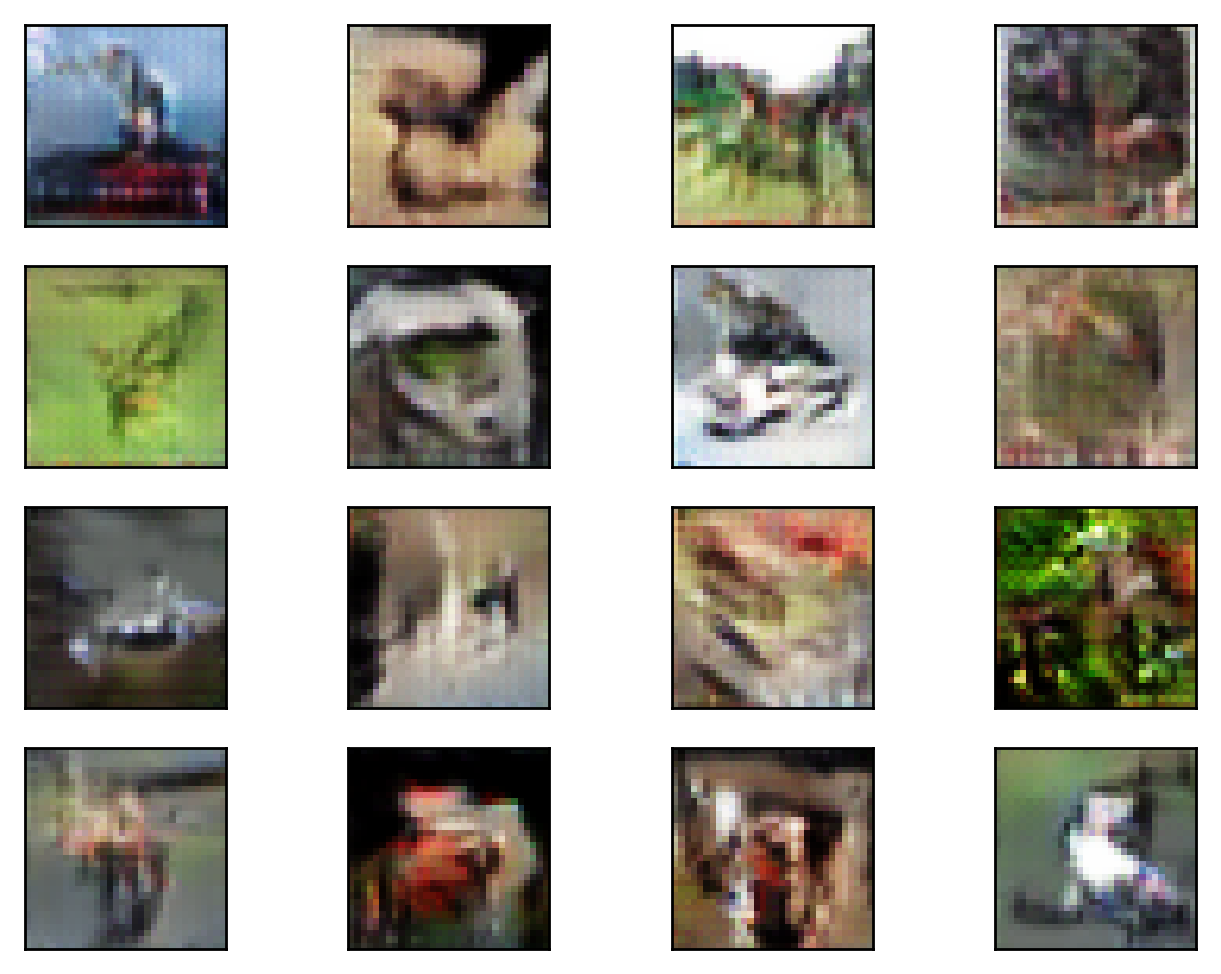

In [39]:
images = []
for i in range(16):
    noise = torch.randn((1, noise_channels, 1, 1)).to(device)
    image = generator(noise).squeeze().detach().cpu().permute(1, 2, 0)
    image = (image + 1)/2
    images.append(image)

fig, axes = plt.subplots(4, 4)
fig.set_dpi(250)
for i, ax in enumerate(axes.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(images[i])